<a href="https://www.kaggle.com/code/ksenia5/transfer-learning-with-inception?scriptVersionId=123246417" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Transfer learning with InceptionV3 for multiclass object detection

The convolutional neural network (CNN) model IncpetionV3 pretrained on Imagenet data is used with transfer learning for image classification with 10 classes of objects.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from tensorflow.keras import layers # look at layers to decide which ones to keep/ retrain
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import pickle
import zipfile
from PIL import Image as im
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Instantiate pre-trained model
pre_trained_model = InceptionV3(input_shape = (224,224,3),
                               include_top = False,
                               weights = 'imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [3]:
# lock pretrained layers
for layer in pre_trained_model.layers:
    layer.trainable = False

In [4]:
# # To view model summary, with layer info
# pre_trained_model.summary()

In [5]:
# Get one of the layers
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
# and its output
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [6]:
# Define new model with output from "mixed7" layer
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation ='relu')(x) # hidden layer with 1024 nodes

# # add drop out to prevent overfitting
# x = layers.Dropout(0.2)(x)
x = layers.Dense(10, activation='softmax')(x) # specify 10 output nodes

model = Model(pre_trained_model.input, x)

# to view model layers
# model.summary()

In [7]:
model.compile(optimizer = RMSprop(lr = 0.001),
             loss = 'categorical_crossentropy',
             metrics= ['accuracy'])

## Load data

In [8]:
pickle_in = open("/kaggle/input/object-detection/X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/kaggle/input/object-detection/y.pickle","rb")
y = pickle.load(pickle_in)
pickle_in.close()

label_dict = pickle.load(open("/kaggle/input/object-detection/label_dict.pickle","rb"))
pickle_in.close()

In [9]:
print(type(X))
print(X.shape)


<class 'numpy.ndarray'>
(950, 224, 224, 3)


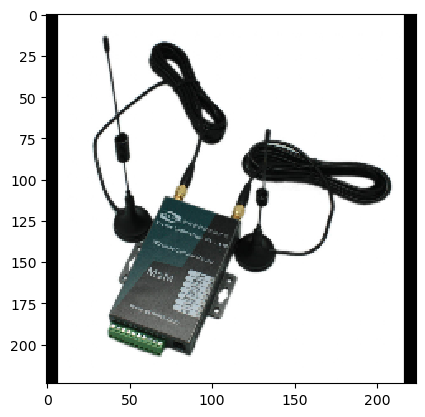

router


In [10]:

plt.imshow(X[0,:,:,:], interpolation='nearest')
plt.show()
print(label_dict[y[0]])

In [11]:
# Split data into training and validation sets
X_train = X[:550,:,:,:]
print("X_train shape", X_train.shape)
X_test = X[550:850,:,:,:]
print("X_test shape", X_test.shape)
X_val = X[850:,:,:,:]
print("X_val shape", X_val.shape)

y_train = y[:550]
y_test = y[550:850]
y_val = y[850:]

X_train shape (550, 224, 224, 3)
X_test shape (300, 224, 224, 3)
X_val shape (100, 224, 224, 3)


In [12]:
# write train test
# for i in range(len(X_train)):
for dataset in ["train", "test", "val"]:
    for label in label_dict.values():
        dir_name = os.path.join("/kaggle/working",dataset, label)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)

for i in range(len(X_train)):
    label = label_dict[y_train[i]]
    image_array = X_train[i,:,:,:]
    img = im.fromarray(image_array,"RGB")
    fpath = os.path.join("/kaggle/working/train",label,label + "_" + str(i) + '.jpg')
    img.save(fpath)

# Write test dataset to required directory structure
for i in range(len(X_test)):
    label = label_dict[y_test[i]]
    image_array = X_test[i,:,:,:]
    img = im.fromarray(image_array,"RGB")
    fpath = os.path.join("/kaggle/working/test",label,label + "_" + str(i) + '.jpg')
    img.save(fpath)

# Write validation dataset to required directory structure
for i in range(len(X_val)):
    label = label_dict[y_val[i]]
    image_array = X_val[i,:,:,:]
    img = im.fromarray(image_array,"RGB")
    fpath = os.path.join("/kaggle/working/val",label,label + "_" + str(i) + '.jpg')
    img.save(fpath)
    
    
#     print(image_array.shape)
#     print(type(image_array))
#     plt.imshow(image_array, interpolation='nearest')
#     plt.show()
#     print(label_dict[y_train[i]])
    
#     img.save('kaggle/working/train/' + label + "_" + str(i) + '.jpg')
    
#     image_.save()
    # saving the final output 
    # as a PNG file
    

In [13]:
# # add data-augmentation parameters to ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale = 1./255.,
#                                    rotation_range = 40,
#                                    width_shift_range = 0.2,
#                                    height_shift_range = 0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip = True)

# test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [14]:
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                    batch_size = 5,
#                                                    class_mode = "categorical",# for multiclass
#                                                    target_size = (224,224))

# validation_generator = train_datagen.flow_from_directory(test_dir,
#                                                    batch_size = 5,
#                                                    class_mode = "categorical",# for multiclass
#                                                    target_size = (224,224))

In [15]:
# # Train the model
# history = model.fit(train_generator,
#                     validation_data = validation_generator,
#                     steps_per_epoch = 100,
#                     # try 100
#                     epochs = 20,
#                     validation_steps = 50,
#                     verbose = 2)

In [16]:
# # Train the model
# history = model.fit(X, y,
#                     steps_per_epoch = 100,
#                     # try 100
#                     epochs = 20,
#                     validation_steps = 50,
#                     verbose = 2)

In [17]:
# # Evaluate the results
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()


# plt.show()

##
